### Coursera Capstone

This notebook will mainly be used for Coursera capstone Project

In [1]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [2]:
import numpy as np # library to handle data in a vectorized manner
%pip install geopy
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as plt

# import k-means from clustering stage
import sklearn
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 112kB 5.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Libraries imported.


Download The Data:

In [3]:
!wget -q -O 'newyork_data.json' https://https://jupyterlab-0.labs.cognitiveclass.ai/user/itsmethehars/lab/LA_data.geojson
print('Data downloaded!')

Data downloaded!


In [5]:
with open('LA_data.geojson') as json_data:
    LA_data = json.load(json_data)

In [6]:
#LA_data

In [7]:
neighborhoods_data = LA_data['features']

In [8]:
neighborhoods_data[1]

{'type': 'Feature',
 'properties': {'external_i': 'adams-normandie',
  'name': 'Adams-Normandie',
  'location': 'POINT(34.031461499124156 -118.30020800000011)',
  'latitude': '-118.30020800000011',
  'slug_1': None,
  'sqmi': '0.805350187789',
  'display_na': 'Adams-Normandie L.A. County Neighborhood (Current)',
  'set': 'L.A. County Neighborhoods (Current)',
  'slug': 'adams-normandie',
  'longitude': '34.031461499124156',
  'name_1': None,
  'kind': 'L.A. County Neighborhood (Current)',
  'type': 'segment-of-a-city'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-118.30900800000012, 34.03741099912408],
     [-118.30040800000013, 34.0373119991241],
     [-118.29150800000001, 34.03681199912407],
     [-118.29140800000012, 34.025511999124234],
     [-118.305408, 34.025711999124255],
     [-118.30900800000012, 34.025611999124216],
     [-118.30900800000012, 34.03741099912408]]]]}}

In [10]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [14]:
for data in neighborhoods_data:
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates'][0][0][0]
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Acton,34.538990,-118.202617
1,Adams-Normandie,34.037411,-118.309008
2,Agoura Hills,34.168203,-118.761925
3,Agua Dulce,34.558304,-118.254677
4,Alhambra,34.105040,-118.121747


In [24]:
print('The dataframe has {} neighborhoods.'.format(
        len(neighborhoods['Neighborhood'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 272 neighborhoods.


In [25]:
#Getting Geographocal Coordinates of LA
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the City of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the City of Los Angeles are 34.0536909, -118.2427666.


In [26]:
# create map of Los Angeles using latitude and longitude values
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

In [17]:
CLIENT_ID = 'PCCC34DXCQGNVB5BJAOHPAZ2N1R5ZIOMEGGTZFIV420LIJAE' # your Foursquare ID
CLIENT_SECRET = '3NRO0RAXWU1OARBFHGGAOSTAPJARYUAZZHHDZZXWGS3NXKZC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PCCC34DXCQGNVB5BJAOHPAZ2N1R5ZIOMEGGTZFIV420LIJAE
CLIENT_SECRET:3NRO0RAXWU1OARBFHGGAOSTAPJARYUAZZHHDZZXWGS3NXKZC


In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    i=1
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name,i)
        i=i+1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
LA_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )


In [20]:
#Drop the categories that are not restaurant:
V1=LA_venues.copy(deep=True)
V2=LA_venues.copy(deep=True)
V1.drop(V1[V1['Venue Category'].str.contains("Restaurant")].index,inplace=True)
for v in V1['Venue Category'].unique():
    V2.drop(V2[V2['Venue Category'] == v].index,inplace=True)
len(V2['Venue Category'].unique())
del(LA_venues)
LA_venues=V2

In [22]:
# Drop the Neighborhoods, where there are no restaurants
print(LA_venues['Neighborhood'].unique().shape)
print(neighborhoods.shape)
LA_venues.head()
nb2=neighborhoods.copy(deep=True)
nb5=neighborhoods.copy(deep=True)
for n in LA_venues['Neighborhood'].unique():
    nb2.drop(nb2[nb2['Neighborhood'] == n].index,inplace=True)
for n in nb2['Neighborhood']:
    nb5.drop(nb5[nb5['Neighborhood'] == n].index,inplace=True)
print(nb5.shape)

(227,)
(816, 3)
(681, 3)


In [23]:
#Total Numbers of Unique Venues
print('There are {} uniques categories.'.format(len(LA_venues['Venue Category'].unique())))

There are 78 uniques categories.


In [27]:
# one hot encoding
LA_onehot = pd.get_dummies(LA_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Neighborhood'] = LA_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Andhra Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Salvadoran Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoshoku Restaurant
3,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Adams-Normandie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
LA_onehot.shape

(14448, 79)

In [29]:
#Group By mean of frequency of occurance of Each Category
LA_grouped = LA_onehot.groupby('Neighborhood').mean().reset_index()
LA_grouped

,Neighborhood,African Restaurant,American Restaurant,Andhra Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Donburi Restaurant,Doner Restaurant,Dongbei Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Salvadoran Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoshoku Restaurant
0,Adams-Normandie,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.069767,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.069767,0.023256,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.023256,0.000000,0.023256,0.000000,0.023256,0.000000,0.023256,0.000000,0.000000,0.348837,0.000000,0.023256,0.000000,0.000000,0.139535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.000000,0.00000,0.046512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000
1,Agoura Hills,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Alhambra,0.000000,0.068966,0.000000,0.000000,0.068966,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.172414,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.103448,0.000000,0.000000,0.000000,0.000000,0.000000,0.137931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.034483,0.034483,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.034483,0.000000,0.000000,0.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.068966,0.000000
3,Alondra Park,0.000000,0.041667,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.020833,0.000000,0.020833,0.020833,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187500,0.000000,0.000000,0.0000

In [30]:
LA_grouped.shape

(227, 79)

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
del(neighborhoods_venues_sorted)
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = LA_grouped['Neighborhood']

for ind in np.arange(LA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

NameError: name 'neighborhoods_venues_sorted' is not defined

Cluster Neighborhoods

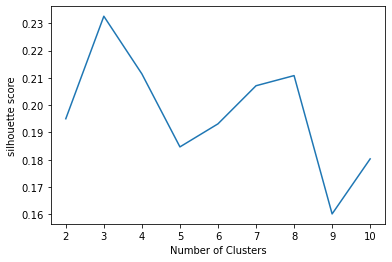

In [33]:
# set number of clusters
sscore=[]
for i in range(2,11):
    kclusters = i

    LA_grouped_clustering = LA_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(LA_grouped_clustering)

    sscore.append(sklearn.metrics.silhouette_score(LA_grouped_clustering, labels=kmeans.labels_))
import matplotlib.pyplot as plt
plt.plot([2,3,4,5,6,7,8,9,10],sscore)
plt.xlabel("Number of Clusters")
plt.ylabel("silhouette score")
plt.show()

In [109]:
#Cluster with K=3
    kclusters = 3

    LA_grouped_clustering = LA_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(LA_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_ 

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0], dtype=int32)

In [110]:
kmeans.labels_.shape

(227,)

In [113]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

LA_merged = nb5

# merge LA_grouped with LA_data to add latitude/longitude for each neighborhood
LA_merged = LA_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

LA_merged.head() 

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Adams-Normandie,34.037411,-118.309008,0,Korean Restaurant,Mexican Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant,Sushi Restaurant,Indian Restaurant,Italian Restaurant,Himalayan Restaurant,Vietnamese Restaurant
2,Agoura Hills,34.168203,-118.761925,0,Japanese Restaurant,Fast Food Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Italian Restaurant,Asian Restaurant,American Restaurant,Argentinian Restaurant,Filipino Restaurant,French Restaurant
4,Alhambra,34.105040,-118.121747,0,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,American Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Mexican Restaurant,Japanese Restaurant,Japanese Curry Restaurant
5,Alondra Park,33.897572,-118.326513,0,Fast Food Restaurant,Vietnamese Restaurant,Mexican Restaurant,Korean Restaurant,Sushi Restaurant,Japanese Restaurant,American Restaurant,Italian Restaurant,Ramen Restaurant,Asian Restaurant
6,Artesia,33.880383,-118.074895,0,Fast Food Restaurant,Chinese Restaurant,American Restaurant,Indian Restaurant,Asian Restaurant,Mexican Restaurant,Filipino Restaurant,Thai Restaurant,Sushi Restaurant,Vietnamese Restaurant


In [115]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_merged['Latitude'], LA_merged['Longitude'], LA_merged['Neighborhood'], LA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [116]:
#Examine Cluster
LA_merged.loc[LA_merged['Cluster Labels'] == 0]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Adams-Normandie,34.037411,-118.309008,0,Korean Restaurant,Mexican Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant,Sushi Restaurant,Indian Restaurant,Italian Restaurant,Himalayan Restaurant,Vietnamese Restaurant
2,Agoura Hills,34.168203,-118.761925,0,Japanese Restaurant,Fast Food Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Italian Restaurant,Asian Restaurant,American Restaurant,Argentinian Restaurant,Filipino Restaurant,French Restaurant
4,Alhambra,34.105040,-118.121747,0,Chinese Restaurant,Fast Food Restaurant,Dumpling Restaurant,American Restaurant,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,Mexican Restaurant,Japanese Restaurant,Japanese Curry Restaurant
5,Alondra Park,33.897572,-118.326513,0,Fast Food Restaurant,Vietnamese Restaurant,Mexican Restaurant,Korean Restaurant,Sushi Restaurant,Japanese Restaurant,American Restaurant,Italian Restaurant,Ramen Restaurant,Asian Restaurant
6,Artesia,33.880383,-118.074895,0,Fast Food Restaurant,Chinese Restaurant,American Restaurant,Indian Restaurant,Asian Restaurant,Mexican Restaurant,Filipino Restaurant,Thai Restaurant,Sushi Restaurant,Vietnamese Restaurant
10,Arleta,34.224103,-118.422015,0,Thai Restaurant,Asian Restaurant,Fast Food Restaurant,Japanese Restaurant,American Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,French Restaurant,English Restaurant
11,Arlington Heights,34.052611,-118.315909,0,Korean Restaurant,Japanese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Sushi Restaurant,Brazilian Restaurant,Seafood Restaurant,Asian Restaurant,Italian Restaurant
13,Atwater Village,34.153007,-118.278325,0,Middle Eastern Restaurant,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Thai Restaurant,Filipino Restaurant,Sushi Restaurant,German Restaurant
14,Avalon,33.354873,-118.330431,0,Seafood Restaurant,Mexican Restaurant,American Restaurant,Caribbean Restaurant,New American Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
15,Avocado Heights,34.025974,-117.965869,0,Mexican Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Asian Restaurant,Sushi Restaurant,South American Restaurant,Seafood Restaurant,Yoshoku Restaurant,English Restaurant


In [117]:
#Examine Cluster
LA_merged.loc[LA_merged['Cluster Labels'] == 1]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Athens,33.930963,-118.291664,1,Fast Food Restaurant,Mexican Restaurant,American Restaurant,Seafood Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
17,Vermont-Slauson,33.993314,-118.280607,1,Fast Food Restaurant,Mexican Restaurant,Seafood Restaurant,Chinese Restaurant,American Restaurant,Latin American Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
18,Baldwin Hills/Crenshaw,34.024836,-118.356261,1,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,American Restaurant,Seafood Restaurant,French Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Southern / Soul Food Restaurant,Ethiopian Restaurant
19,Baldwin Park,34.107064,-117.942953,1,Fast Food Restaurant,Mexican Restaurant,American Restaurant,Thai Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Yoshoku Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
21,Bellflower,33.908971,-118.138574,1,Fast Food Restaurant,Mexican Restaurant,Japanese Restaurant,American Restaurant,Seafood Restaurant,Chinese Restaurant,Restaurant,Argentinian Restaurant,Thai Restaurant,New American Restaurant
22,Bell Gardens,33.973973,-118.148570,1,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,American Restaurant,Spanish Restaurant,Salvadoran Restaurant,Chinese Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
24,Bell,33.998113,-118.165504,1,Mexican Restaurant,Fast Food Restaurant,Latin American Restaurant,Seafood Restaurant,Chinese Restaurant,Mediterranean Restaurant,Restaurant,Korean Restaurant,Greek Restaurant,Gluten-free Restaurant
31,Boyle Heights,34.061811,-118.192705,1,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,Restaurant,Chinese Restaurant,Mediterranean Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
34,Broadway-Manchester,33.960014,-118.278207,1,Fast Food Restaurant,American Restaurant,Southern / Soul Food Restaurant,Yoshoku Restaurant,German Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
37,Carson,33.886268,-118.257605,1,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,American Restaurant,Restaurant,Asian Restaurant,Italian Restaurant,Hawaiian Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant


In [118]:
#Examine Cluster
LA_merged.loc[LA_merged['Cluster Labels'] == 2]

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Burbank,34.221654,-118.292761,2,American Restaurant,Yoshoku Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
98,Hansen Dam,34.273347,-118.368321,2,American Restaurant,Yoshoku Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
206,San Pedro,33.761717,-118.243705,2,American Restaurant,Yoshoku Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
209,Shadow Hills,34.272354,-118.340656,2,American Restaurant,Yoshoku Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
211,Sierra Madre,34.179405,-118.065651,2,American Restaurant,Yoshoku Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
